# Development of a Nonlinear Structural Stability Constraint for Aeroelastic Optimization

This notebook shows how to produce the figures published in the paper titled _Development of a Nonlinear Structural Stability Constraint for Aeroelastic Optimization_, presented at the AIAA SciTech Forum in January 2024 and authored by Francesco M. A. Mitrotta, Alberto Pirrera, Terence Macquart, Jonathan E. Cooper, Alex Pereira do Prado and Pedro Higino Cabral.

* [Nonlinear structural stability of the CRM-like box beam](#crm-like-box-beam)
* [Optimization of the CRM-like box beam with nonlinear structural stability constraints](#optimization)
    * [Optimization with linear buckling constraints](#linear-buckling)
        * [Nonlinear analysis of linearly optimized design](#nonlinear-analysis)
    * [Optimization with nonlinear structural stability constraints](#nonlinear-structural-stability)

In [1]:
import os  # package for interacting with the operating system
import matplotlib.pyplot as plt  # package for creating figures and plots
from matplotlib.lines import Line2D  # class holding the list of markers
import tol_colors as tc  # package for colorblind-friendly colors
import numpy as np  # package for scientific computing

# Define name of directory where to save analyses and figures
analysis_directory_name = "SciTech_2024"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", analysis_directory_name)
optimization_results_directory_name = "20_Two-variables_Optimization_of_the_CRM-like_Box_Beam"
OPTIMIZATION_RESULTS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", optimization_results_directory_name)  # path to optimization results

TEXTWIDTH_INCHES = 6.498998  # paper textwidth in inches
FIG_WIDTH_INCHES = TEXTWIDTH_INCHES*.5
FIG_HEIGHT_INCHES = FIG_WIDTH_INCHES*(4.8/6.4)  # default figure height in inches

DEFAULT_FONT_SIZE = 8  # default font size of figures
DEFAULT_MARKER_SIZE = 3  # default marker size of lines
plt.rcParams.update({'figure.dpi': 120,  # default figure dpi
                     'text.usetex': True,  # use LaTeX to render text
                     'font.family': 'serif',  # use serif rather than sans-serif
                     'font.serif': "Times New Roman",  # use Times New Roman
                     'font.size': DEFAULT_FONT_SIZE,  # default font size of figures
                     'mathtext.fontset': 'stix',  # use Times New Roman for math
                     'lines.markersize': DEFAULT_MARKER_SIZE})  # set default marker size of lines

MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors
UNSTABLE_COLOR = COLORS[1]  # red
GLASS_CEILING_COLOR = COLORS[2]  # green
del COLORS[1:3]  # delete green and red from list of colors

np.set_printoptions(precision=1, suppress=True)

FIRST_SUBCASE_ID = 1  # id of first subcase
SECOND_SUBCASE_ID = 2  # id of second subcase
Z_COMPONENT_INDEX = 2  # index of z-component in vector of displacements

## Nonlinear structural stability of the CRM-like box beam <a name="crm-like-box-beam"></a>

***


In [2]:
l = 29.38e3  # [mm] box beam length
w = 3.41e3  # [mm] box beam width
h = 0.77e3  # [mm] box beam height
t = h/100  # [mm] initial box beam thickness
stiffeners_height = h/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = w/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(l/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # [mm] ribs y-coordinates
print(f"Number of stiffeners per skin: {no_stiffeners:d}\nNumber of ribs: {no_ribs:d}")  # print number of stiffeners and ribs
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

Number of stiffeners per skin: 2
Number of ribs: 19


Plot buckling mode of converged mesh.

subcase=0 already exists...skipping


Nastran job initial_box_beam_linear_buckling.bdf completed
Wall time: 9.0 s


Buckling load: 12419 N


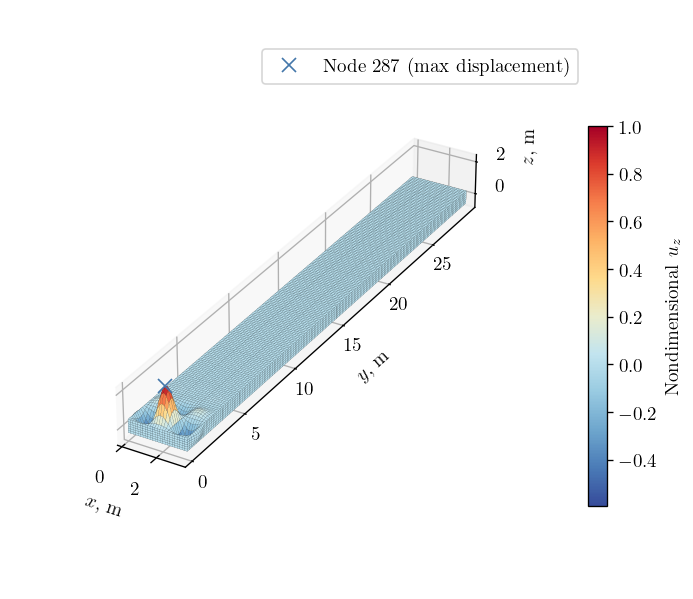

In [3]:
from resources import pynastran_utils, box_beam_utils  # import modules with utility functions

def apply_tip_concentrated_load(bdf_input, force_id):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = t/10  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/10 of the cross-sectional thickness
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) &
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) | (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |
                          (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                       comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=[master_node_id], set_id=force_id, direction_vector=force_direction)
    # Return id of master node
    return master_node_id

force_set_id = 11  # define FORCE card identification number
eigenvalue_calculation_subcase_id = 2  # define subcase id of eigenvalue calculation
cquad4_element_length = 169.6  # [mm]

# Generate base bdf input
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations,
                                                                    stiffeners_height=stiffeners_height, element_length=cquad4_element_length)
nodes_xyz_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
sol_105_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                   nodes_xyz_array=nodes_xyz_array,
                                                   nodes_connectivity_matrix=nodes_connectivity_matrix)
# Apply concetrated load at the tip
apply_tip_concentrated_load(sol_105_bdf, force_set_id)

# Run SOL 105 and return OP2 object
input_name = "initial_box_beam_linear_buckling"
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=sol_105_bdf, static_load_set_id=force_set_id,
                                                            analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
                                                            run_flag=False)
# Find critical buckling load and print it
sol_105_buckling_load = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f"Buckling load: {sol_105_buckling_load:.0f} N")

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 70  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Plot buckling mode
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7),
                     'lines.markersize': 8})  # increase default font size
amplification_factor = 2  # amplification factor for displacements
fig, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id,
                                                   displacement_component='tz', colormap='sunset', length_unit='m',
                                                   displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[
    0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[
    max_displacement_index, 0]
local_displacement_node_ids = [max_displacement_node_id]  # initialize list of node ids where to plot local displacements

# Plot node where maximum displacement occurs
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend(bbox_to_anchor=(1., .95))

# Adjust plot, show it and save figure
adjust_3d_plot(ax, cbar)
plt.show()
bbox = fig.bbox_inches.from_bounds(.7, .5, 5.5, 4.)  # create bounding box for figure
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "InitialBoxBeamBucklingMode.png"), format='png', bbox_inches=bbox, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Run nonlinear analysis and plot load-displacement diagrams.

In [4]:
# Create BDF obejct and apply concentrated load at the tip
sol_106_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_mesh.points,
                                                    box_beam_mesh.faces.reshape(-1, 5)[:, 1:])
tip_master_node_id = apply_tip_concentrated_load(sol_106_bdf, force_set_id)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
fine_nlparm_id = 1  # id of NLPARM card with fine arc-length method parameters
pynastran_utils.set_up_arc_length_method(bdf_object=sol_106_bdf, ninc=100, conv='PU', max_iter=3, eps_p=1e-5,
                                         eps_u=1e-5, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=3, maxinc=2000)

# Apply load and create subcase
load_set_id = force_set_id + 1  # id of load set
scale_factor = np.round(sol_105_buckling_load)*2  # scale factor to apply to the load set
sol_106_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])  # add LOAD card
pynastran_utils.create_static_load_subcase(bdf_object=sol_106_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with static load

# Run SOL 106 and return OP2 object
method_set_id = load_set_id + 1
no_eigenvalues = 20
input_name = "initial_box_beam_nonlinear_analysis"
input_label = "initial structure"
sol_106_op2 = {input_label: pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=sol_106_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)}

subcase=0 already exists...skipping


Nastran job initial_box_beam_nonlinear_analysis.bdf completed
Wall time: 10524.0 s


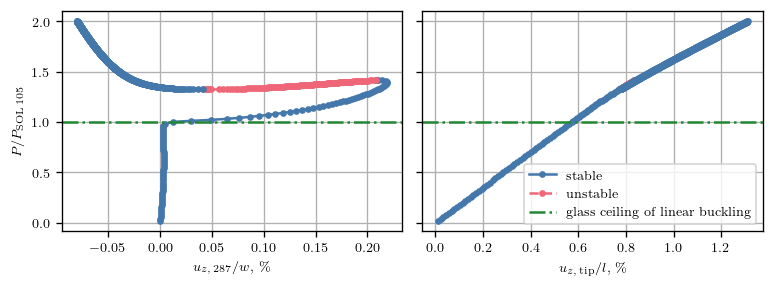

In [5]:
# Define function to plot load-displacement diagram segment by segment
def plot_segments(eigvals, axes, disp, loads, marker, color):
    negative_eigenvalues_mask = (eigvals < 0).any(axis=0)
    unstable_segments = []  # list to store indices of unstable segments
    stable_segments = []  # list to store indices of stable segments
    # Loop through the negative_eigenvalues_mask to identify and plot segments
    for i, is_negative in enumerate(negative_eigenvalues_mask):
        if is_negative:
            if stable_segments:
                # Plot the stable segment if there was one before
                stable_segments.append(i)  # make the stable segment finish at the first point of the unstable segment
                axes.plot(disp[stable_segments], loads[stable_segments], marker + "-", color=color)
                stable_segments = []  # reset the stable segment indices
            unstable_segments.append(i)  # add the current index to the unstable segment, this will overwrite the blue point with a red one
        else:
            if unstable_segments:
                # Plot the unstable segment if there was one before
                unstable_segments.append(i)  # make the unstable segment finish at the first point of the stable segment
                axes.plot(disp[unstable_segments], loads[unstable_segments], marker + "--", color=UNSTABLE_COLOR)
                unstable_segments = []  # reset the unstable segment indices
            stable_segments.append(i)  # add the current index to the stable segment, this will overwrite the red point with a blue one
    # Plot the remaining segments if any
    if stable_segments:
        axes.plot(disp[stable_segments], loads[stable_segments], marker + "-", color=color)
    if unstable_segments:
        axes.plot(disp[unstable_segments], loads[unstable_segments], marker + "--", color=UNSTABLE_COLOR)

# Create one figure with two subplots side by side
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES))

# Read and store applied loads and local displacements
_, applied_loads, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=max_displacement_node_id)
nondimensional_applied_loads = {input_label: applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / sol_105_buckling_load}
nondimensional_root_displacements = {input_label: local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / w}

# Read eigenvalues
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = {input_label: pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)}

# Plot on the first subplot
plot_segments(eigenvalues[input_label], axes[0], nondimensional_root_displacements[input_label]*100, nondimensional_applied_loads[input_label], MARKERS[0], COLORS[0])

# Read and store tip displacements
_, _, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=tip_master_node_id)
nondimensional_tip_displacements = {input_label: tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / l}

# Plot on the second subplot
plot_segments(eigenvalues[input_label], axes[1], nondimensional_tip_displacements[input_label]*100, nondimensional_applied_loads[input_label], MARKERS[0], COLORS[0])

# Plot the line of the glass ceiling of linear buckling for final design on both subplots
for ax in axes:
    ax.axhline(y=1, color=GLASS_CEILING_COLOR, linestyle='-.')

# Create proxy artists for the legend
stable_line = Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="stable")
unstable_line = Line2D([0], [0], linestyle='--', marker=MARKERS[0], color=UNSTABLE_COLOR, label="unstable")
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="glass ceiling of linear buckling")
axes[1].legend(handles=[stable_line, unstable_line, glass_ceiling_line], loc="best")

# Set plot appearance for the first subplot
axes[0].set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{SOL\,105}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "InitialBoxBeamLoadDisplacement.svg"), format='svg', bbox_inches='tight', pad_inches=0)


Plot deformation before and adter snap.

Deformation before snap:


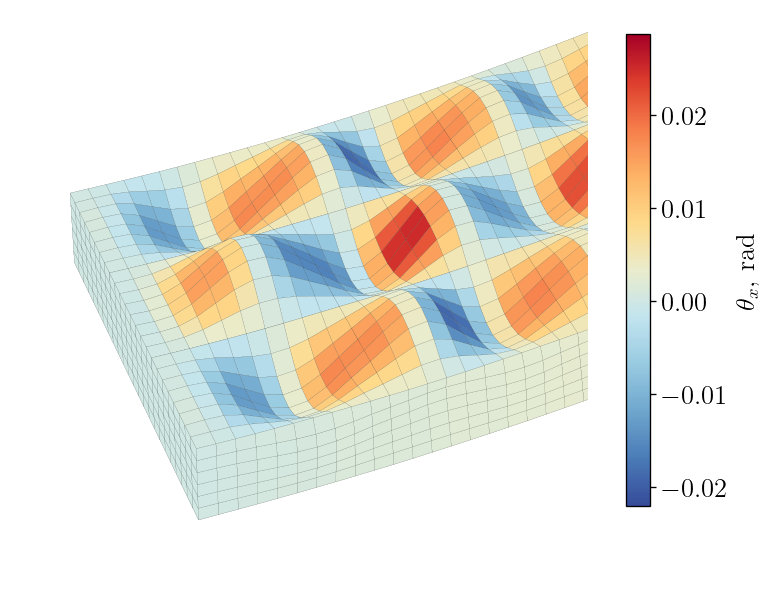

Deformation after snap:


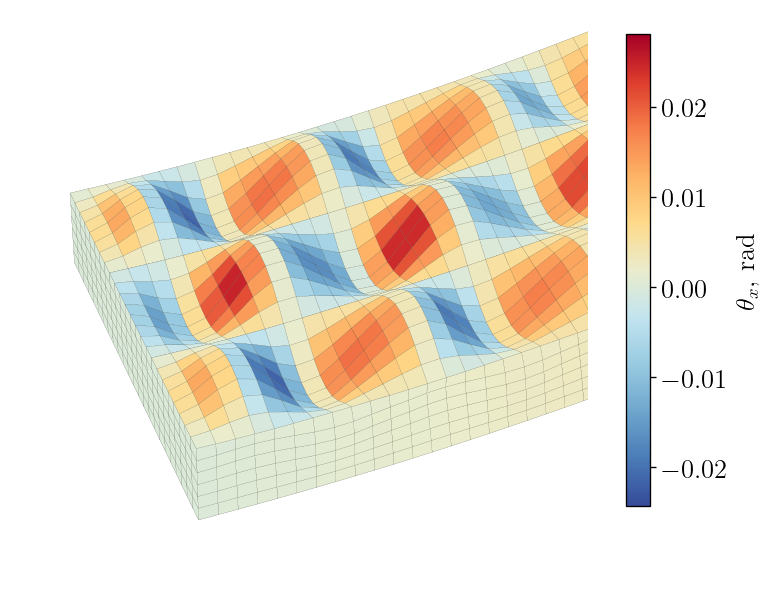

In [6]:
# Plot deformation just before limit point
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*2})  # increase default font size because figures are plotted side by side
first_negative_eigenvalue_index = np.where(eigenvalues[input_label][0, :] < 0)[0][0]  # find index of first negative eigenvalue
print("Deformation before snap:")
amplification_factor = 50  # amplification factor for displacements
fig, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[input_label], subcase_id=FIRST_SUBCASE_ID,
                                                        load_step=first_negative_eigenvalue_index, displacement_component='rx',
                                                        colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                        displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
ax.set_xlim(0, w*1e-3)
ax.set_ylim(0, 4*h*1e-3)
ax.set_zlim(-h/2*1e-3, h*1e-3)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in 'xyz')])
plt.axis('off')
ax.view_init(40, -20)
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "BeforeSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Find closest converged iteration to applied load after limit point
subsequent_values = nondimensional_applied_loads[input_label][first_negative_eigenvalue_index + 10:]
nondimensional_applied_load_before_limit_point = nondimensional_applied_loads[input_label][first_negative_eigenvalue_index - 1]  # find applied load just before limit point
closest_index_in_subsequent = np.argmin(np.abs(subsequent_values - nondimensional_applied_load_before_limit_point))
closest_index = first_negative_eigenvalue_index + closest_index_in_subsequent
print("Deformation after snap:")

# Plot deformation after limit point
fig, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[input_label], subcase_id=FIRST_SUBCASE_ID,
                                                        load_step=closest_index + 1, displacement_component='rx', colormap='sunset',
                                                        length_unit='m', unit_scale_factor=1e-3,
                                                        displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
ax.set_xlim(0, w*1e-3)
ax.set_ylim(0, 4*h*1e-3)
ax.set_zlim(-h/2*1e-3, h*1e-3)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
plt.axis('off')
ax.view_init(40, -20)
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "AfterSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Plot eigenvalues of the tangent stiffness matrix.

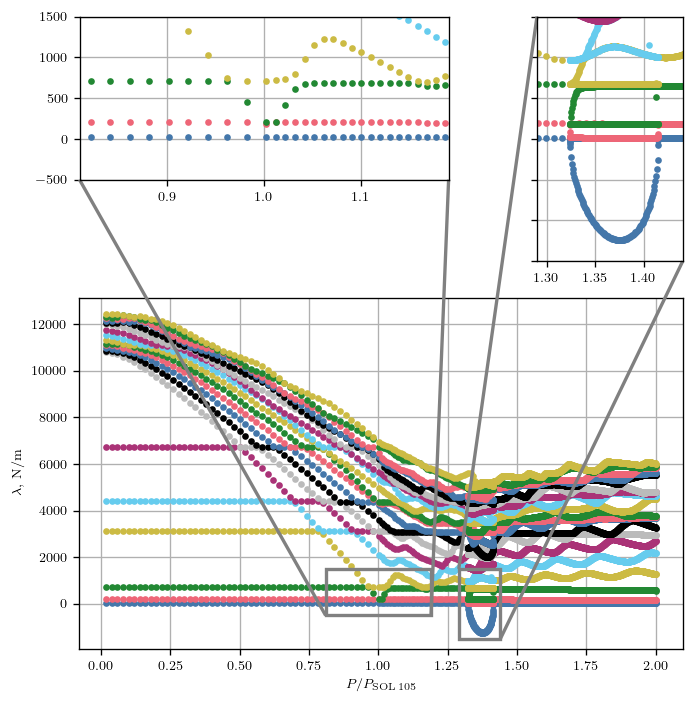

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

# Create the figure
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES*2.5))
fig.subplots_adjust(top=.59)

# Plot eigenvalues vs applied load
plt.plot(nondimensional_applied_loads[input_label], eigenvalues[input_label].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda,\,\mathrm{N/m}$")
plt.xlabel("$P/P_\mathrm{SOL\,105}$")
plt.grid(True)

# Define zoom level
zoom_level = 3.5

# Create the first zoomed inset
x1, x2 = .81, 1.19  # region of interest for the first zoomed inset
axins1 = zoomed_inset_axes(ax, zoom_level, loc="upper left", bbox_to_anchor=(-.01, 1.82), bbox_transform=ax.transAxes)
axins1.plot(nondimensional_applied_loads[input_label], eigenvalues[input_label].T * 1e3, 'o')
axins1.set_xlim(x1, x2)  # adjust the limits as needed
axins1.set_ylim(-500, 1500)  # adjust the limits as needed
axins1.set_xticks([0.9, 1.0, 1.1])
mark_inset(ax, axins1, loc1=3, loc2=4, fc='none', ec='0.5', linewidth=2, zorder=2)  # connect to the region of interest
axins1.grid(True)

# Create the second zoomed inset
x1, x2 = 1.29, 1.44  # region of interest for the second zoomed inset
axins2 = zoomed_inset_axes(ax, zoom_level, loc="upper right", bbox_to_anchor=(1.01, 1.82), bbox_transform=ax.transAxes)
axins2.plot(nondimensional_applied_loads[input_label], eigenvalues[input_label].T * 1e3, 'o')
axins2.set_xlim(x1, x2)  # adjust the limits based on your region of interest
axins2.set_ylim(-1500, 1500)  # adjust the limits as needed
axins2.tick_params(labelleft=False, labelbottom=True)
mark_inset(ax, axins2, loc1=2, loc2=4, fc='none', ec='0.5', linewidth=2, zorder=2)  # connect to the region of interest
axins2.grid(True)

# Adjust layout for better appearance
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "Eigenvalues.svg"), format='svg', pad_inches=0, bbox_inches='tight')

## Optimization of the CRM-like box beam with nonlinear structural stability constraints <a name="optimization"></a>

***


### Optimization with linear buckling constraints <a name="linear-buckling"></a>

Mass variation: -21.7 %
Final thickness vector [mm]:
[8.1 4. ]
Final KS value of buckling load factor: 0.0
Final KS value for stress: -400 MPa


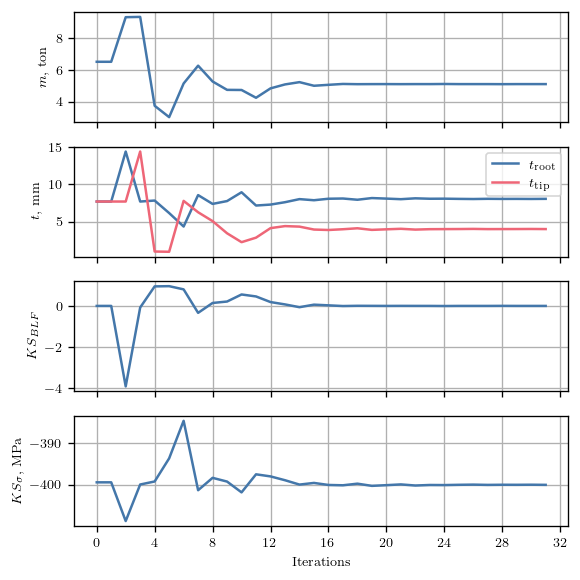

In [8]:
import openmdao.api as om  # make available the most common OpenMDAO classes and functions
from matplotlib.ticker import MaxNLocator  # import class to set the number of ticks of an axis

# Instantiate CaseReader object
cr = om.CaseReader(os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, "sol_105_optimization.sql"))  # path to cases database

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases('driver', recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ['sol_105.mass', 'interp.t_cp', 'sol_105.ks_buckling', 'sol_105.ks_stress']  # keys of the functions to retrieve
histories = {key: np.array([case[key] for case in driver_cases]) for key in keys}  # retrieve histories of the functions

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_0 = histories["sol_105.mass"][0, 0]
mass_percentage_variation = (histories['sol_105.mass'][-1, 0]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.1f} %
Final thickness vector [mm]:""")
print(histories['interp.t_cp'][-1])
print(f"""Final KS value of buckling load factor: {histories['sol_105.ks_buckling'][-1, 0]:.1f}
Final KS value for stress: {histories['sol_105.ks_stress'][-1, 0]:.0f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES*2))

# Plot mass history
iterations_array = np.arange(len(histories['sol_105.mass']))
ax1.plot(iterations_array, histories['sol_105.mass'])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories['interp.t_cp'])
ax2.set(ylabel="$t$, mm")
ax2.grid()
ax2.legend(["$t_\mathrm{root}$", "$t_\mathrm{tip}$"], loc="best")


# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories['sol_105.ks_buckling'])
ax3.set(ylabel="$KS_{BLF}$")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories['sol_105.ks_stress'])
ax4.set(xlabel="Iterations", ylabel="$KS_{\sigma}$, MPa")
ax4.grid()
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))

# Show plot
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "LinearBucklingOptimizationHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot critical buckling mode of optimized structure.

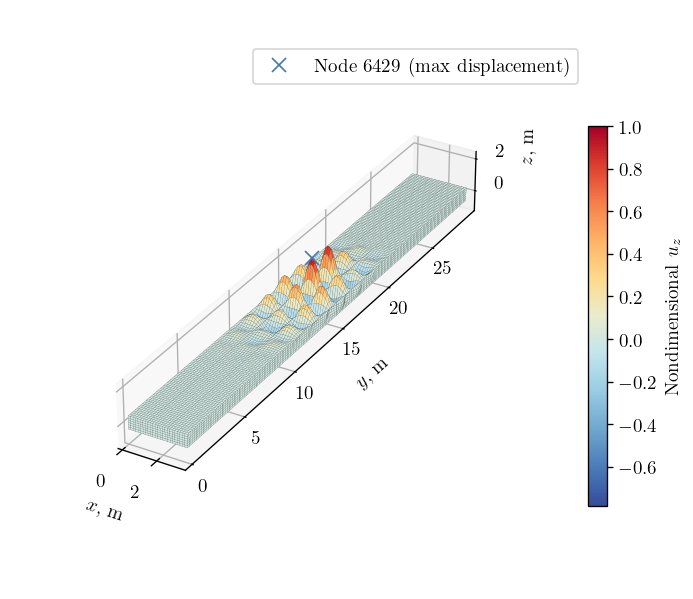

In [9]:
from pyNastran.op2.op2 import read_op2  # pyNastran function to read op2 files

# Read op2 file of linear buckling analysis
sol_105_op2_filepath = os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, 'linear_opt_sol_105' + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]
local_displacement_node_ids.append(max_displacement_node_id)  # add node id to list of node ids to plot local displacements

# Plot buckling mode
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7),
                     'lines.markersize': 8})  # increase default font size
amplification_factor = 2  # amplification factor for displacements
fig, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend(bbox_to_anchor=(1., .95))

# Adjust plot, show it and save figure
adjust_3d_plot(ax, cbar)
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "LinearOptimizedBucklingMode.png"), format='png', bbox_inches=bbox, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

#### Nonlinear analysis of linearly optimized design <a name="nonlinear-analysis"></a>

Read displacements of initial and linearly optimized structure.

In [10]:
# Read local displacements at the mid-length for initial structure
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=max_displacement_node_id)
nondimensional_midlength_displacements = {input_label: local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / w}

# Read op2 file of nonlinear analysis of linearly optimized design
linear_optimized_sol_106_input_name = "linear_opt_sol_106_epsp1e-5"
sol_106_op2_filepath = os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, linear_optimized_sol_106_input_name + '.op2')
input_label = "linearly optimized structure"
sol_106_op2[input_label] = read_op2(op2_filename=sol_106_op2_filepath, load_geometry=True, debug=None)

# Read applied loads, tip displacements and eigenvalues for linearly optimized structure
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=tip_master_node_id)
nondimensional_applied_loads[input_label] = applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / sol_105_buckling_load
nondimensional_tip_displacements[input_label] = tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / l
f06_path = os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, linear_optimized_sol_106_input_name + '.f06')  # path to .f06 file
eigenvalues[input_label] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Read and plot local displacements at the root for linearly optimized structure
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=local_displacement_node_ids[0])
nondimensional_root_displacements[input_label] = local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / w

# Read and plot local displacements at midlength for linearly optimized structure
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=local_displacement_node_ids[1])
nondimensional_midlength_displacements[input_label] = local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / w

Plot load-displacement diagrams.

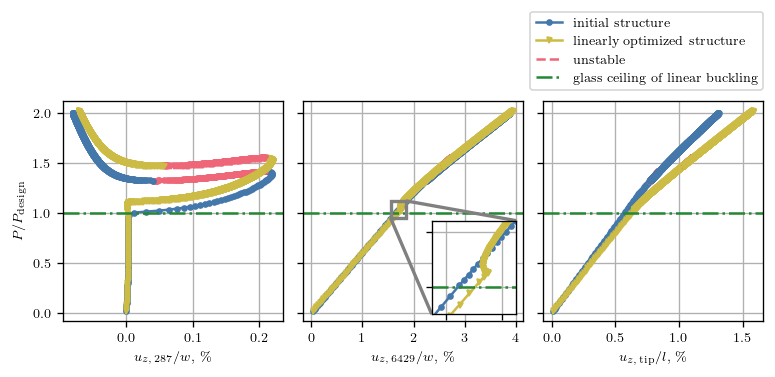

In [11]:
# Create one figure with two subplots side by side
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES))

# Plot load-displacement diagrams
input_labels = ["initial structure", "linearly optimized structure"]
for count, label in enumerate(input_labels):
    plot_segments(eigenvalues[label], axes[0], nondimensional_root_displacements[label]*100,
                  nondimensional_applied_loads[label], MARKERS[count], COLORS[count])
    plot_segments(eigenvalues[label], axes[1], nondimensional_midlength_displacements[label]*100,
                  nondimensional_applied_loads[label], MARKERS[count], COLORS[count])
    plot_segments(eigenvalues[label], axes[2], nondimensional_tip_displacements[label]*100,
                  nondimensional_applied_loads[label], MARKERS[count], COLORS[count])

# Plot the line of the glass ceiling of linear buckling on all subplots
for ax in axes:
    ax.axhline(y=1, color=GLASS_CEILING_COLOR, linestyle='-.')

# Create proxy artists for the legend
stable_lines = [Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="initial structure"),
                Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="linearly optimized structure")]
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=stable_lines + [unstable_line, glass_ceiling_line], loc="upper right", bbox_to_anchor=(.99, 1.28))

# Set plot appearance
axes[0].set_xlabel(f"$u_{{z,\,{local_displacement_node_ids[0]:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)
axes[1].set_xlabel(f"$u_{{z,\,{local_displacement_node_ids[1]:d}}}/w$, \%")
axes[1].grid(visible=True)
axes[2].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[2].grid(visible=True)
plt.tight_layout()  # Ensures proper spacing between subplots

# Plot zoomed inset of central displacement
zoom_level = 5.5
x1, x2 = 1.55, 1.85  # x-axis limits for the zoomed inset
y1, y2 = 0.95, 1.12  # y-axis limits for the zoomed inset
axins = zoomed_inset_axes(axes[1], zoom_level, loc="lower right")  # create zoomed inset
for count, label in enumerate(input_labels):  # plot load-displacement diagram of initial and linearly optimized structure
    plot_segments(eigenvalues[label], axins, nondimensional_midlength_displacements[label]*100,
                  nondimensional_applied_loads[label], MARKERS[count], COLORS[count])
axins.axhline(y=1, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling of linear buckling
axins.set_xlim(x1, x2)  # adjust the limits as needed
axins.set_ylim(y1, y2)  # adjust the limits as needed
mark_inset(axes[1], axins, loc1=3, loc2=1, fc='none', ec='0.5', linewidth=2, zorder=2)  # connect to the region of interest
axins.grid(True)
axins.tick_params(labelleft=False, labelbottom=False)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "LinearOptimizedBoxBeamLoadDisplacement.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Calculate load of loss of stability for linearly optimized structure.

In [12]:
first_negative_eigenvalue_index = np.where(eigenvalues[input_label][0, :] < 0)[0][0]  # find index of first negative eigenvalue
nondimensional_applied_load_limit_point = nondimensional_applied_loads[input_label][first_negative_eigenvalue_index]  # calculate applied load at limit point as the mean of the applied loads between positive and negative eigenvalue
print(f"Nondimensional applied load at limit point: {nondimensional_applied_load_limit_point:.2f}")

Nondimensional applied load at limit point: 1.54


Plot eigenvalues of the tangent stiffness matrix.

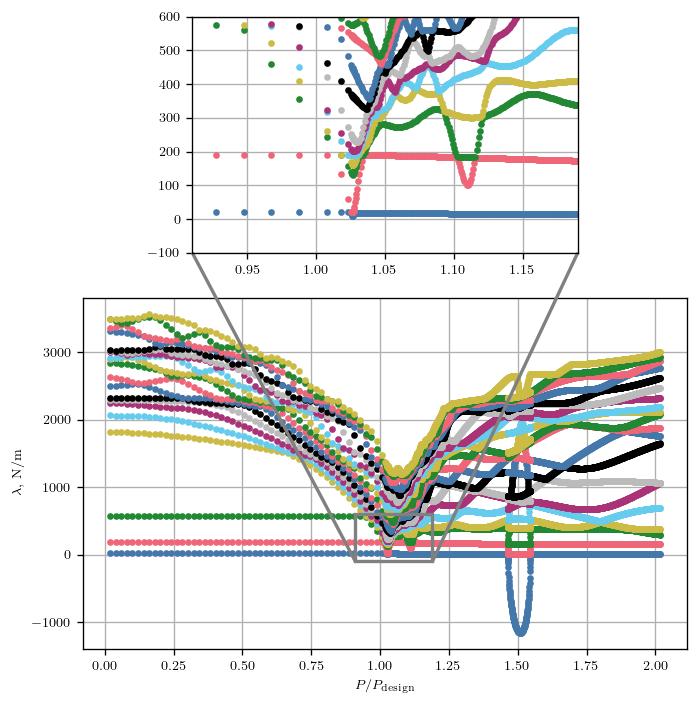

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

# Create the figure
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES*2.5))
fig.subplots_adjust(top=.59)

# Plot eigenvalues vs applied load
plt.plot(nondimensional_applied_loads[input_label], eigenvalues[input_label].T*1e3, "o")  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda,\,\mathrm{N/m}$")
plt.xlabel("$P/P_\mathrm{design}$")
plt.grid(True)

# Create the first zoomed inset
zoom_level = 5.
x1, x2 = .91, 1.19  # load range for the first zoomed inset
y1, y2 = -100, 600  # eigenvalue range for the first zoomed inset
axins1 = zoomed_inset_axes(ax, zoom_level, loc="upper center", bbox_to_anchor=(.5, 1.82), bbox_transform=ax.transAxes)
axins1.plot(nondimensional_applied_loads[input_label], eigenvalues[input_label].T * 1e3, 'o')
axins1.set_xlim(x1, x2)  # adjust the limits as needed
axins1.set_ylim(y1, y2)  # adjust the limits as needed
mark_inset(ax, axins1, loc1=3, loc2=4, fc='none', ec='0.5', linewidth=2, zorder=2)  # connect to the region of interest
axins1.grid(True)

# Create the second zoomed inset
# zoom_level = 2.
# x1, x2 = 1.41, 1.59  # load range for the second zoomed inset
# y1, y2 = -1200, 550  # eigenvalue range for the second zoomed inset
# axins2 = zoomed_inset_axes(ax, zoom_level, loc="upper right", bbox_to_anchor=(1.01, 1.82), bbox_transform=ax.transAxes)
# axins2.plot(nondimensional_applied_loads[input_label], eigenvalues[input_label].T * 1e3, 'o')
# axins2.set_xlim(x1, x2)  # adjust the limits based on your region of interest
# axins2.set_ylim(y1, y2)  # adjust the limits as needed
# # axins2.tick_params(labelleft=False, labelbottom=True)
# mark_inset(ax, axins2, loc1=2, loc2=4, fc='none', ec='0.5', linewidth=2, zorder=2)  # connect to the region of interest
# axins2.grid(True)

# Adjust layout for better appearance
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "LinearOptimizedEigenvalues.svg"), format='svg', pad_inches=0, bbox_inches='tight')

Plot deformation at design load of initial and linearly optimized structures.

Deformation at design load of initial structure:


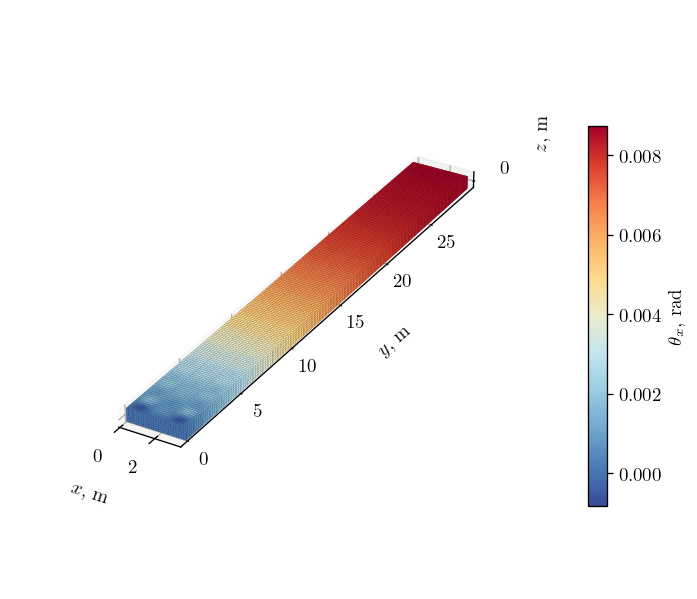

Deformation at design load of linearly optimized structure:


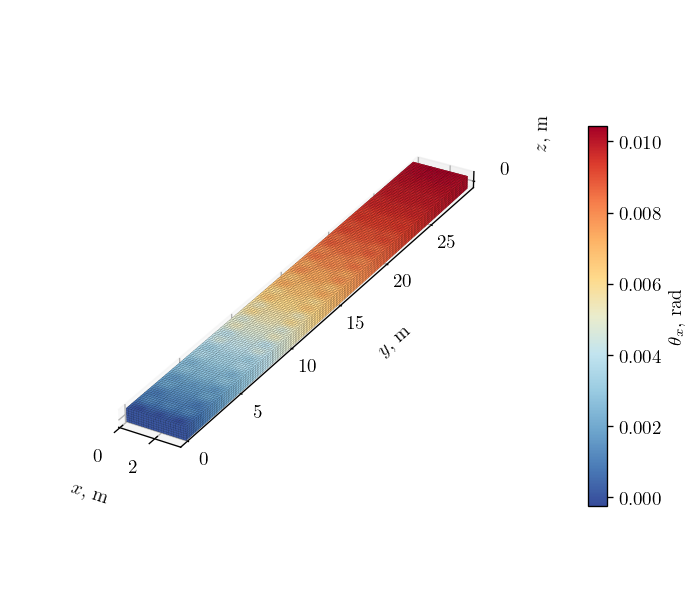

In [14]:
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7)})  # increase default font size because figures are rendered side by side in the paper
structures_to_compare = ["initial structure", "linearly optimized structure"]  # list of structures to compare
for key in structures_to_compare:
    print(f"Deformation at design load of {key}:")
    design_load_index = np.argmin(np.abs(nondimensional_applied_loads[key] - 1))  # find index of design load
    fig, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[key], subcase_id=FIRST_SUBCASE_ID, displacement_component='rx',
                                                            colormap='sunset', length_unit='m', unit_scale_factor=1e-3, load_step=design_load_index + 1)  # plot deformation converting from mm to m
    ax.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    ax.set_zticks([0])  # set ticks of z-axis
    ax.tick_params(axis='y', which='major', pad=40)  # adjust position of ticks' label of y-axis
    ax.tick_params(axis='z', which='major', pad=10)  # adjust position of ticks' label of z-axis
    ax.xaxis.labelpad = 10  # adjust position of x-axis's label
    ax.yaxis.labelpad = 150  # adjust position of y-axis's label
    ax.zaxis.labelpad = 20  # adjust position of z-axis's label
    cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
    cbar.ax.set_position(cbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards
    plt.show()
    fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, f"deformation_{key.replace(' ', '_')}.png"), format='png', bbox_inches=bbox, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

### Optimization with nonlinear structural stability constraints <a name="nonlinear-structural-stability"></a>

Mass variation: -26.5 %
Final thickness vector [mm]:
[7.9 1. ]
Final KS value of nonlinear structural stability: 30.87 N/m
Final KS value for stress: -379 MPa


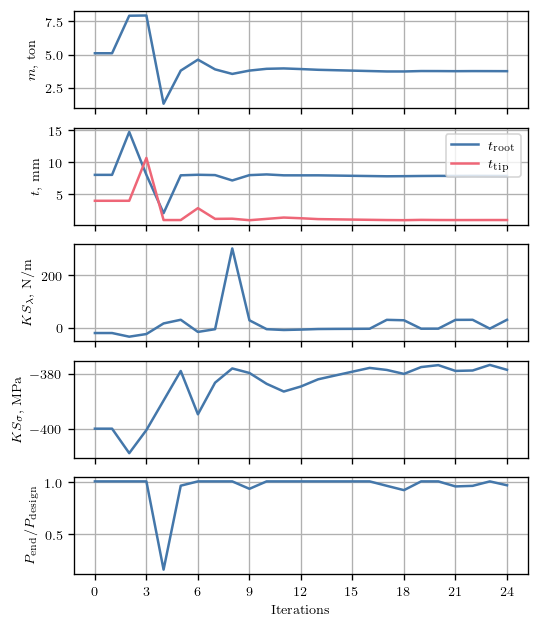

In [15]:
# Instantiate CaseReader object
cr = om.CaseReader(os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, "sol_106_optimization.sql"))  # path to cases database

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases('driver', recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ["sol_106.mass", "interp.t_cp", "sol_106.ks_stability", "sol_106.ks_stress", "sol_106.applied_load"]  # keys of the functions to retrieve
histories = {key: np.array([case[key] for case in driver_cases]) for key in keys}  # retrieve histories of the functions

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_0 = histories["sol_106.mass"][0, 0]
mass_percentage_variation = (histories["sol_106.mass"][-1, 0]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.1f} %
Final thickness vector [mm]:""")
print(histories['interp.t_cp'][-1])
print(f"""Final KS value of nonlinear structural stability: {histories["sol_106.ks_stability"][-1, 0]:.2f} N/m
Final KS value for stress: {histories["sol_106.ks_stress"][-1, 0]:.0f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES*2.5))

# Plot mass history
iterations_array = np.arange(len(histories['sol_106.mass']))
ax1.plot(iterations_array, histories['sol_106.mass'])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories['interp.t_cp'])
ax2.set(ylabel="$t$, mm")
ax2.grid()
ax2.legend(["$t_\mathrm{root}$", "$t_\mathrm{tip}$"], loc="best")

# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories["sol_106.ks_stability"])
ax3.set(ylabel="$KS_{\lambda},\,\mathrm{N/m}$")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories["sol_106.ks_stress"])
ax4.set(ylabel="$KS_{\sigma},\,\mathrm{MPa}$")
ax4.grid()

# Plot applied load history
ax5.plot(iterations_array, histories["sol_106.applied_load"]/sol_105_buckling_load)
ax5.set(xlabel="Iterations", ylabel="$P_\mathrm{end}/P_\mathrm{design}$")
ax5.xaxis.set_major_locator(MaxNLocator(integer=True))
ax5.grid()

# Show plot
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "NonlinearStructuraStabilityOptimizationHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Calculate linear buckling load of nonlinearly optimized design.

P_sol105/P_design = 0.05
Buckling mode:


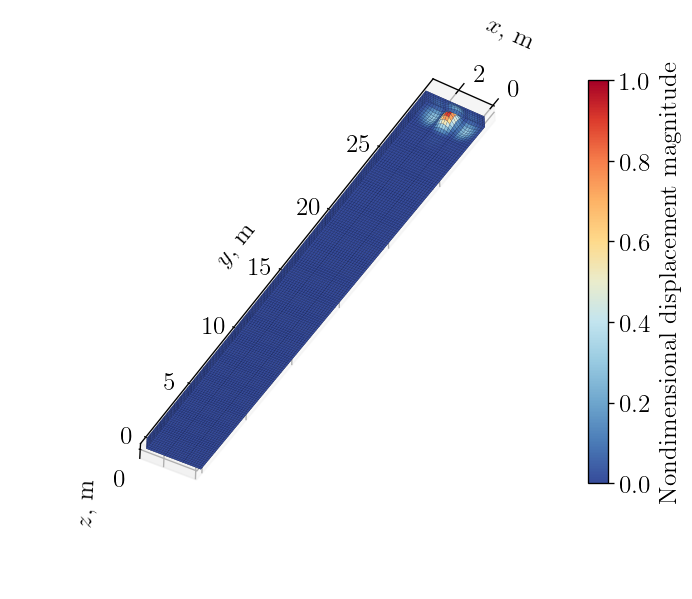

In [16]:
# Read op2 file of linear buckling analysis
sol_105_op2_filepath = os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, 'nonlinear_opt_sol_105' + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find buckling load
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
print(f"P_sol105/P_design = {buckling_load_factor:.2f}")

# Plot buckling mode
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*1.9,
                     'lines.markersize': 8})  # increase default font size
amplification_factor = .8  # amplification factor for displacements
print("Buckling mode:")
fig, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                   length_unit='m', colormap='sunset',
                                                   displacement_amplification_factor=amplification_factor,
                                                   unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Adjust plot, show it and save figure
ax.view_init(-45, 60)
ax.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
ax.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
ax.tick_params(axis="y", which="major", pad=50)  # adjust position of ticks' label of y-axis
ax.set_zticks([0])  # set ticks of z-axis
ax.yaxis.labelpad = 110  # adjust position of y-axis's label
ax.zaxis.labelpad = 10  # adjust position of z-axis's label
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .7))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(-.05, .18))  # move colorbar upwards
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "NonlinearOptimizedBucklingMode.png"), format='png', bbox_inches=bbox, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Plot load-displacement diagrams.

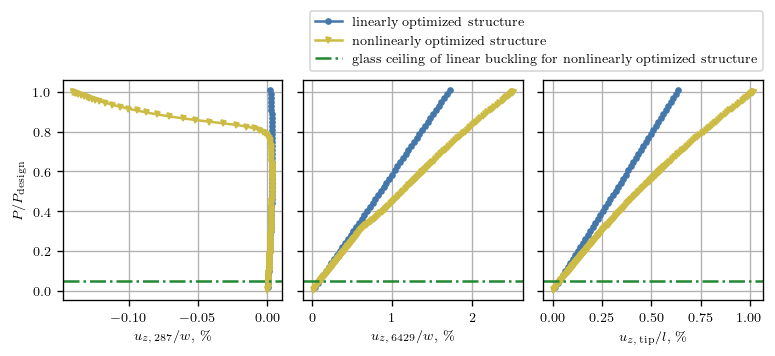

In [17]:
# Create one figure with two subplots side by side
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES))

# Plot local and tip displacements for the linearly optimized structure
plot_segments(eigenvalues[input_label][:, :design_load_index + 1], axes[0], nondimensional_root_displacements[input_label][:design_load_index + 1]*100,
              nondimensional_applied_loads[input_label][:design_load_index + 1], MARKERS[0], COLORS[0])
plot_segments(eigenvalues[input_label][:, :design_load_index + 1], axes[1], nondimensional_midlength_displacements[input_label][:design_load_index + 1]*100,
              nondimensional_applied_loads[input_label][:design_load_index + 1], MARKERS[0], COLORS[0])
plot_segments(eigenvalues[input_label][:, :design_load_index + 1], axes[2], nondimensional_tip_displacements[input_label][:design_load_index + 1]*100,
              nondimensional_applied_loads[input_label][:design_load_index + 1], MARKERS[0], COLORS[0])

# Read op2 file of nonlinear analysis of nonlinearly optimized design
input_name = "nonlinear_opt_sol_106"
input_label = "nonlinearly optimized structure"
sol_106_op2_filepath = os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, input_name + '.op2')
sol_106_op2[input_label] = read_op2(op2_filename=sol_106_op2_filepath, load_geometry=True, debug=None)

# Read applied loads, tip displacements and eigenvalues for linearly optimized structure
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=tip_master_node_id)
nondimensional_applied_loads[input_label] = applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / sol_105_buckling_load
nondimensional_tip_displacements[input_label] = tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / l
f06_path = os.path.join(OPTIMIZATION_RESULTS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Read and plot local displacements at the root for nonlinearly optimized structure
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=local_displacement_node_ids[0])
nondimensional_root_displacements[input_label] = local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / w
plot_segments(eigenvalues, axes[0], nondimensional_root_displacements[input_label]*100, nondimensional_applied_loads[input_label], MARKERS[1], COLORS[1])

# Read and plot local displacements at midlength for nonlinearly optimized structure
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[input_label], displacement_node_id=local_displacement_node_ids[1])
nondimensional_midlength_displacements[input_label] = local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / w
plot_segments(eigenvalues, axes[1], nondimensional_midlength_displacements[input_label]*100, nondimensional_applied_loads[input_label], MARKERS[1], COLORS[1])

# Plot tip displacements for nonlinearly optimized structure
plot_segments(eigenvalues, axes[2], nondimensional_tip_displacements[input_label]*100, nondimensional_applied_loads[input_label], MARKERS[1], COLORS[1])

# Plot the line of the glass ceiling of linear buckling for final design on both subplots
for ax in axes:
    ax.axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')

# Create proxy artists for the legend
stable_lines = [Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="linearly optimized structure"),
                Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="nonlinearly optimized structure")]
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="glass ceiling of linear buckling for nonlinearly optimized structure")
fig.legend(handles=stable_lines + [glass_ceiling_line], loc="upper right", bbox_to_anchor=(.99, 1.21))

# Set plot appearance for the first subplot
axes[0].set_xlabel(f"$u_{{z,\,{local_displacement_node_ids[0]:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel(f"$u_{{z,\,{local_displacement_node_ids[1]:d}}}/w$, \%")
axes[1].grid(visible=True)

# Set plot appearance for the third subplot
axes[2].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[2].grid(visible=True)

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "NonlinearOptimizedBoxBeamLoadDisplacement.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot eigenvalues.

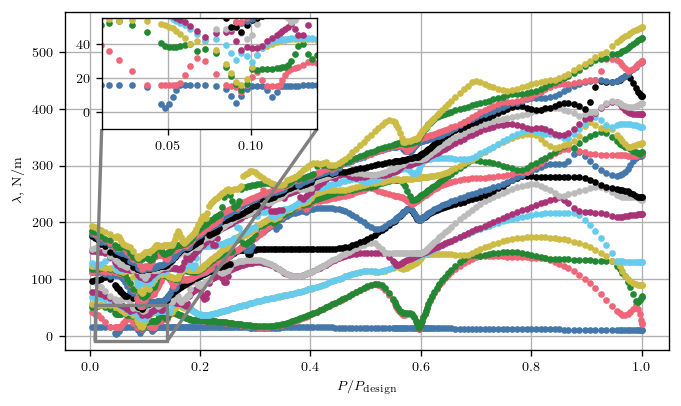

In [18]:
# Plot eigenvalues vs applied load
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES*1.5))
ax.plot(nondimensional_applied_loads[input_label], eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)

# Plot zoomed inset
zoom_level = 3.
x1, x2 = 0.01, 0.14  # x-axis limits for the zoomed inset
y1, y2 = -10, 55  # y-axis limits for the zoomed inset
axins = zoomed_inset_axes(ax, zoom_level, loc="upper left", bbox_to_anchor=(.05, 1.), bbox_transform=ax.transAxes)
axins.plot(nondimensional_applied_loads[input_label], eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
axins.set_xlim(x1, x2)  # adjust the limits as needed
axins.set_ylim(y1, y2)  # adjust the limits as needed
mark_inset(ax, axins, loc1=3, loc2=4, fc='none', ec='0.5', linewidth=2, zorder=2)  # connect to the region of interest
axins.grid(True)
# axins.tick_params(labelleft=False, labelbottom=False)

plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, "NonlinearOptimizedEigenvalues.svg"), format='svg', pad_inches=0, bbox_inches='tight')

Plot deformation at design load.

Deformation at design load of nonlinearly optimized structure:


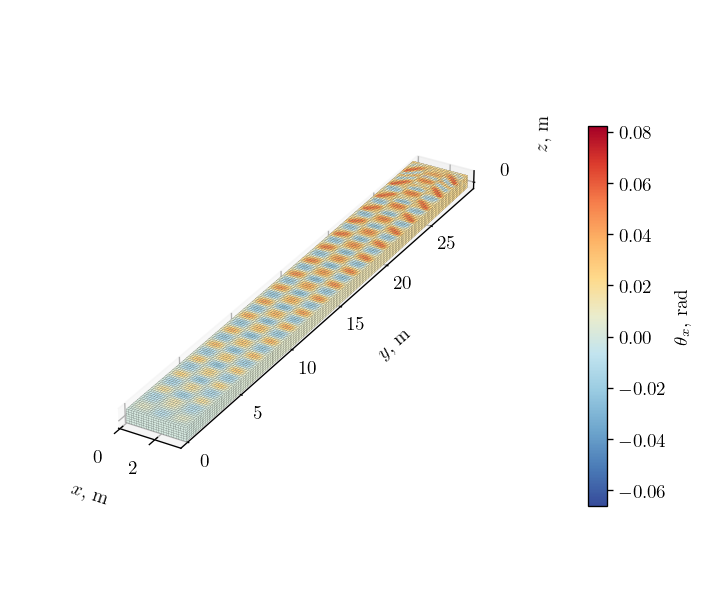

In [19]:
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7)})  # increase default font size because figures are rendered side by side in the paper
print(f"Deformation at design load of nonlinearly optimized structure:")
fig, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[input_label], subcase_id=FIRST_SUBCASE_ID, displacement_component='rx',
                                                            colormap='sunset', length_unit='m', unit_scale_factor=1e-3)  # plot deformation converting from mm to m
ax.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
ax.set_zticks([0])  # set ticks of z-axis
ax.tick_params(axis='y', which='major', pad=40)  # adjust position of ticks' label of y-axis
ax.tick_params(axis='z', which='major', pad=10)  # adjust position of ticks' label of z-axis
ax.xaxis.labelpad = 10  # adjust position of x-axis's label
ax.yaxis.labelpad = 150  # adjust position of y-axis's label
ax.zaxis.labelpad = 20  # adjust position of z-axis's label
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards
plt.show()
fig.savefig(os.path.join(ANALYSIS_DIRECTORY_PATH, f"deformation_{input_label.replace(' ', '_')}.png"), format='png', bbox_inches=bbox, pad_inches=0, dpi=500)